Import packages:

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

Read in the data:

In [192]:
# read the data
datapath = "data/university_data/"

cwurData = pd.read_csv(datapath + "/cwurData.csv", header=0)
cwurData = cwurData.rename(columns={'institution': 'university_name'})

shanghaiData = pd.read_csv(datapath + "/shanghaiData.csv", header=0)
shanghaiData = shanghaiData[pd.notna(shanghaiData['university_name'])] #delete one row that is NAs only

timesData = pd.read_csv(datapath + "/timesData.csv", header=0)

In the world_rank columns are also non-integer characters. We get rid of them to cast the column to int64:

In [193]:
#timesData[timesData.world_rank.str.contains('[^0-9]' ,regex = True)]['world_rank'].unique()

#replacing for example '201-250' with mean(201,250)
rangeRanks = timesData[timesData.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for range in rangeRanks:
    parts = range.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[range] = str(avg)
timesData = timesData.replace({"world_rank": rangeRanksToAvg})

rangeRanks = shanghaiData[shanghaiData.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for range in rangeRanks:
    parts = range.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[range] = str(avg)
shanghaiData = shanghaiData.replace({"world_rank": rangeRanksToAvg})

#replacing for example '=127' with 127
timesData['world_rank'] = timesData['world_rank'].apply(lambda x : re.sub("[^0-9]", "", str(x)))

timesData = timesData.astype({'world_rank': 'int64'})
shanghaiData = shanghaiData.astype({'world_rank': 'int64'})

Same countries are referred differently across the datasets. There are also some typos in these columns. So we try to standardize them:

In [194]:
#timesCountries = timesData['country'].unique()
#cwurCountries = cwurData['country'].unique()

#timesCountriesFiltered = [x for x in timesCountries if x not in cwurCountries]
#cwurCountriesFiltered = [x for x in cwurCountries if x not in timesCountries]

#getting the same country names
countriesDict = {'United States of America':'USA',
                 'Unisted States of America':'USA',
                 'Unted Kingdom':'United Kingdom',
                 'Republic of Ireland':'Ireland',
                 'Russian Federation':'Russia',
                 'Slovakia':'Slovak Republic'}

timesData = timesData.replace({"country": countriesDict})

timesCountries = timesData['country'].unique()
cwurCountries = cwurData['country'].unique()

timesCountriesFiltered = [x for x in timesCountries if x not in cwurCountries]
cwurCountriesFiltered = [x for x in cwurCountries if x not in timesCountries]

#timesCountriesFiltered
#cwurCountriesFiltered

Same universities are referred differently across the datasets. So we try to standardize them:

In [195]:
#timesUnis = timesData['university_name'].unique()
#cwurUnis = cwurData['university_name'].unique()

#timesUnisFiltered = [x for x in timesUnis if x not in cwurUnis]
#cwurUnisFiltered = [x for x in cwurUnis if x not in timesUnis]

#I tried to get the same university_names, but its simply to tedious...
unisDict = {'ETH Zurich – Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Michigan':'University of Michigan, Ann Arbor',
            'University of Washington':'University of Washington - Seattle',
            'University of Illinois at Urbana-Champaign':'University of Illinois at Urbana–Champaign',
            'Washington University in St Louis':'Washington University in St. Louis',
            'University of Wisconsin':'University of Wisconsin–Madison',
            'University of Minnesota':'University of Minnesota, Twin Cities',
            'Massachusetts Institute of Technology (MIT)':'Massachusetts Institute of Technology',
            'University of Wisconsin - Madison':'University of Wisconsin–Madison',
            'The University of Tokyo':'University of Tokyo',
            'University of Michigan - Ann Arbor':'University of Michigan, Ann Arbor',
            'The Imperial College of Science, Technology and Medicine':'Imperial College London',
            'Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Colorado at Boulder':'University of Colorado Boulder',
            'The University of Texas at Austin':'University of Texas at Austin',
            'The University of Texas Southwestern Medical Center at Dallas':'University of Texas Southwestern Medical Center',
            'The University of Edinburgh':'University of Edinburgh'}

timesData = timesData.replace({"university_name": unisDict})
shanghaiData = shanghaiData.replace({"university_name": unisDict})

timesUnis = timesData['university_name'].unique()
shanghaiUnis = shanghaiData['university_name'].unique()
cwurUnis = cwurData['university_name'].unique()

timesUnisFiltered = [x for x in timesUnis if x not in shanghaiUnis]
shanghaiUnisFiltered = [x for x in shanghaiUnis if x not in cwurUnis]
cwurUnisFiltered = [x for x in cwurUnis if x not in shanghaiUnis]
#cwurUnisFiltered = [x for x in cwurUnis if x not in timesUnis]

#timesUnisFiltered
#shanghaiUnisFiltered
#cwurUnisFiltered

The shanghai Dataset does not contain country information. We add it by joining it with the other dataframes:

In [196]:
#get countries of universities for shanghaiData
uniCountryDf = pd.concat([timesData[['university_name', 'country']], cwurData[['university_name', 'country']]]).drop_duplicates()
shanghaiData = pd.merge(shanghaiData, uniCountryDf, how='left', on='university_name')
shanghaiData['country'] = shanghaiData['country'].fillna('unknown')

Some visualization how University of Vienna and TU Vienna changed over time in the different surveys:

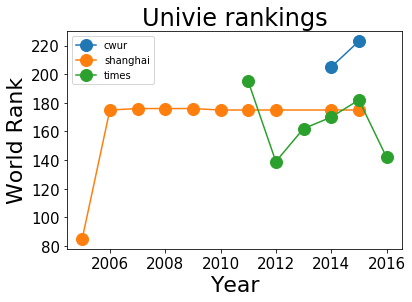

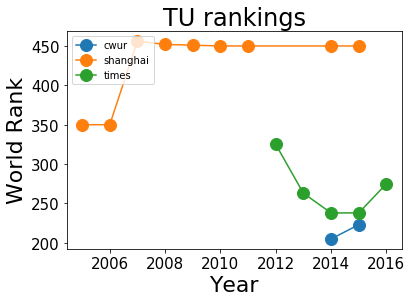

In [197]:
cwur_univie = cwurData[cwurData.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
cwur_univie['survey'] = "cwur"
times_univie = timesData[timesData.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
times_univie['survey'] = "times"
shanghai_univie = shanghaiData[shanghaiData.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
shanghai_univie['survey'] = "shanghai"
all_surveys_univie = cwur_univie.append(times_univie).append(shanghai_univie)

cwur_TU = cwurData[cwurData.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
cwur_TU['survey'] = "cwur"
times_TU = timesData[timesData.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
times_TU['survey'] = "times"
shanghai_TU = shanghaiData[shanghaiData.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
shanghai_TU['survey'] = "shanghai"
all_surveys_TU = cwur_UoV.append(times_TU).append(shanghai_TU)

groups_univie = all_surveys_univie.groupby('survey')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_univie:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("Univie rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

groups_TU = all_surveys_TU.groupby('survey')

fig, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_TU:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("TU rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

Creating Dataframes where only the best University of each country of each year is stored. In the Shanghai Dataframe are unknown countries which we could replace by googling - especially for the years 2012 - 2015.

In [198]:
#only keeps the best university of each country for each year in the df. Necessary for timesData, because it has not national rank column.
def countryRanks(df):
    workdf = df.set_index(['year', 'world_rank']).sort_index()
    country_ranks = workdf.head(1)
    last_country = country_ranks.iloc[-1]['country']
    last_year = country_ranks.index[-1][0]
    workdf = workdf[(workdf.country != last_country) | (workdf.index.get_level_values('year') != last_year)]
    while not(workdf.empty):
        country_ranks = country_ranks.append(workdf.head(1))
        last_country = country_ranks.iloc[-1]['country']
        last_year = country_ranks.index[-1][0]
        workdf = workdf[(workdf.country != last_country) | (workdf.index.get_level_values('year') != last_year)]
    
    return country_ranks[['university_name', 'country']]
    
times_country_ranks = countryRanks(timesData)

cwur_country_ranks = cwurData[cwurData.national_rank == 1].set_index(['year', 'world_rank']).sort_index()
cwur_country_ranks = cwur_country_ranks[['university_name', 'country']]

#replacing for example '201-250' with min(201,250) in national_ranks column
rangeRanks = shanghaiData[shanghaiData.national_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['national_rank'].unique()
rangeRanksToMin = {}
for range in rangeRanks:
    parts = range.split('-')
    rangeRanksToMin[range] = str(parts[0])
shanghaiData = shanghaiData.replace({"national_rank": rangeRanksToMin})
shanghaiData = shanghaiData.astype({'national_rank': 'float'}).astype({'national_rank': 'int64'})

shanghai_country_ranks = shanghaiData[shanghaiData.national_rank == 1].set_index(['year', 'world_rank']).sort_index()
shanghai_country_ranks = shanghai_country_ranks[['university_name', 'country']]

shanghai_country_ranks


university_name  \
year world_rank                                                    
2005 1                                        Harvard University   
     2                                   University of Cambridge   
     20                                      University of Tokyo   
     24                                    University of Toronto   
     27          Swiss Federal Institute of Technology in Zurich   
     41                                       Utrecht University   
     45                                     Karolinska Institute   
     46             Pierre and Marie  Curie University - Paris 6   
     51                                     University of Munich   
     56                       The Australian National University   
     57                                 University of Copenhagen   
     67                                  Moscow State University   
     69                                       University of Oslo   
     76                                   University of Helsinki   
     78                       The Hebrew University of Jerusalem   
     85                                     University of Vienna   
     97                         University of Roma - La Sapienza   
     126                           Catholic University of Leuven   
     126                          Catholic University of Louvain   
     126                                        Ghent University   
     126                        National University of Singapore   
     126                               Seoul National University   
     126                              University Libre Bruxelles   
     126                                 University of Sao Paulo   
     177                         Autonomous University of Madrid   
     177                National Autonomous University of Mexico   
     177                              National Taiwan University   
     177                                     Tsinghua University   
     177                                 University of Barcelona   
     251                            Charles University in Prague   
...                                                          ...   
2015 175                     The Chinese University of Hong Kong   
     175                             The University of Hong Kong   
     175                                  Trinity College Dublin   
     175                                 University of Barcelona   
     175                              University of Buenos Aires   
     175                                     University of Milan   
     175                                     University of Padua   
     175                                      University of Pisa   
     175                                     University of Turin   
     175                                    University of Vienna   
     250                            Charles University in Prague   
     250                National Autonomous University of Mexico   
     250                              The University of Auckland   
     250                                 University of Cape Town   
     250                                    University of Lisbon   
     250                                     University of Otago   
     250                                    University of Tehran   
     250                         University of the Witwatersrand   
     350                             Indian Institute of Science   
     350                                 Jagiellonian University   
     350          National and Kapodistrian University of Athens   
     350                                  University of Belgrade   
     350                                     University of Chile   
     350                                    University of Malaya   
     350                                    University of Warsaw   
     450                                        Cairo University   
     450                             